`TTbarResCoffea` Notebook to perform the data-driven mistag-rate-based ttbar hadronic analysis. 
This module must be run twice: 
   1. Make the mistag rate in the "anti-tag and probe" selection 
and the expectation in the signal region from MC,
   1. Applies that mistag rate and the mod-mass procedure to the single-tag selection. 

These are all done in bins of
b-tag categories (0, 1, $\ge 2$) and rapidity ($|y| \le 1.0$, $|y| > 1.0$).
The signal region is two top-tagged jets. 
The background estimate is the single-tag selection weighted by the mistag rate from the
"anti-tag and probe" region, with the mass of the weighted jet set to a random
value from QCD MC in the 1-ttag region. 


The preselection is:
- AK4-based $H_{T} > 1100$ GeV (to be on the trigger plateau). 
- $\ge 2$ AK8 jets with AK8 $p_{T} > 400$ GeV and $|y| < 2.5$, loose jet ID applied from matched AK4 jets

The 1-tag selection adds:
- $\ge 1$ AK8 jet with top tagging applied to randomly-assigned tag jet. 


The anti-tag selection is disjoint from the 1-tag selection:
- $\ge 1$ AK8 jet with top tagging VETO applied to randomly-assigned tag jet. 


The 2-tag selection is:
- $\ge 2$ AK8 jets with top tagging applied to both leading jets. 


The ttbar candidate mass assumes the two leading top-tagged jets are the top quarks. 


In [1]:
import time

from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
import coffea.processor as processor
from coffea import util
from awkward import JaggedArray
import numpy as np
import glob as glob
import itertools
import pandas as pd
from numpy.random import RandomState

In [2]:
xrootdstr1 = 'root://cmseos.fnal.gov//'
xrootdstr2 = 'root://cmsxrootd.fnal.gov//'
xrootdstr3 = 'root://cmsxrootd-site.fnal.gov/'

In [3]:
qcdfilename = 'QCD.txt'
with open(qcdfilename) as f:
    qcdfiles = [xrootdstr2 + s.strip() for s in f.readlines()]

In [4]:
ttbarfilename = 'TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8.txt'
with open(ttbarfilename) as f:
    ttbarfiles = [xrootdstr2 + s.strip() for s in f.readlines()]

In [5]:
jetdatafilename = 'JetHT_Data.txt'
with open(jetdatafilename) as f:
    jetdatafiles = [xrootdstr2 + s.strip() for s in f.readlines()[::3]] # Every third datafile
with open(jetdatafilename) as g:
    jetdatafiles2016 = [xrootdstr2 + s.strip() for s in g.readlines() if "/store/data/Run2016" in s]
with open(jetdatafilename) as h:
    jetdatafiles2017 = [xrootdstr2 + s.strip() for s in h.readlines() if "/store/data/Run2017" in s]
with open(jetdatafilename) as i:
    jetdatafiles2018 = [xrootdstr2 + s.strip() for s in i.readlines() if "/store/data/Run2018" in s]

In [6]:
#print(jetdatafiles[2]) # Test to see if correct files are collected

In [7]:
from columnservice.client import ColumnClient
cc = ColumnClient("coffea-dask.fnal.gov")
client = cc.get_dask()

In [8]:
manual_bins = []
ix = 400
while ix <= 7000:
    manual_bins.append(ix)
    if ix < 1000:
        ix += 50
    elif ix < 2000:
        ix += 100
    elif ix < 4000:
        ix += 500
    elif ix < 5000:
        ix += 1000
    else:
        ix += 2000
print(manual_bins)

[400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2500, 3000, 3500, 4000, 5000, 7000]


In [9]:

"""@TTbarResAnaHadronic Package to perform the data-driven mistag-rate-based ttbar hadronic analysis. 
"""
class TTbarResProcessor(processor.ProcessorABC):
    def __init__(self, prng, htCut=950., minMSD=105., maxMSD=210., tau32Cut=0.65, ak8PtMin=400., bdisc=0.7,
                writePredDist=True,isData=True,year=2019, UseLookUpTables=False,
                lu = None):
        
        self.prng = prng
        self.htCut = htCut
        self.minMSD = minMSD
        self.maxMSD = maxMSD
        self.tau32Cut = tau32Cut
        self.ak8PtMin = ak8PtMin
        self.bdisc = bdisc
        self.writePredDist = writePredDist
        self.writeHistFile = True
        self.isData = isData
        self.year=year
        self.UseLookUpTables = UseLookUpTables
        self.lu = lu # Look Up Tables
        
        self.ttagcats = ["At","at", "0t", "1t", "2t"] #anti-tag+probe, anti-tag, 0, 1, >=2 ttags
        self.btagcats = ["0b", "1b", "2b"]   # 0, 1, >=2 btags
        self.ycats = ['cen', 'fwd']          # Central and forward
        # Combine categories like "0bcen", "0bfwd", etc:
        self.anacats = [ t+b+y for t,b,y in itertools.product( self.ttagcats, self.btagcats, self.ycats) ]
        print(self.anacats)
        
        dataset_axis = hist.Cat("dataset", "Primary dataset")
        cats_axis = hist.Cat("anacat", "Analysis Category")
        
        jetmass_axis = hist.Bin("jetmass", r"Jet $m$ [GeV]", 50, 0, 500)
        jetpt_axis = hist.Bin("jetpt", r"Jet $p_{T}$ [GeV]", 50, 0, 5000)
        ttbarmass_axis = hist.Bin("ttbarmass", r"$m_{t\bar{t}}$ [GeV]", 50, 0, 5000)
        jeteta_axis = hist.Bin("jeteta", r"Jet $\eta$", 50, -5, 5)
        jetphi_axis = hist.Bin("jetphi", r"Jet $\phi$", 50, -np.pi, np.pi)
        jety_axis = hist.Bin("jety", r"Jet $y$", 50, -3, 3)
        jetdy_axis = hist.Bin("jetdy", r"Jet $\Delta y$", 50, 0, 3)
        #jetp_axis = hist.Bin("jetp", r"Jet $p$ [GeV]", 100, 0, 10000)
        manual_axis = hist.Bin("jetp", r"Jet Momentum [GeV]", manual_bins)
        
        subjetmass_axis = hist.Bin("subjetmass", r"SubJet $m$ [GeV]", 50, 0, 500)
        subjetpt_axis = hist.Bin("subjetpt", r"SubJet $p_{T}$ [GeV]", 50, 0, 2000)
        subjeteta_axis = hist.Bin("subjeteta", r"SubJet $\eta$", 50, -4, 4)
        subjetphi_axis = hist.Bin("subjetphi", r"SubJet $\phi$", 50, -np.pi, np.pi)

        self._accumulator = processor.dict_accumulator({
            'ttbarmass': hist.Hist("Counts", dataset_axis, cats_axis, ttbarmass_axis),
            'jetmass':   hist.Hist("Counts", dataset_axis, cats_axis, jetmass_axis),
            'jetpt':     hist.Hist("Counts", dataset_axis, cats_axis, jetpt_axis),
            'jeteta':    hist.Hist("Counts", dataset_axis, cats_axis, jeteta_axis),
            'probept':     hist.Hist("Counts", dataset_axis, cats_axis, jetpt_axis),
            'probep':     hist.Hist("Counts", dataset_axis, cats_axis, manual_axis),

            'jetphi':    hist.Hist("Counts", dataset_axis, cats_axis, jetphi_axis),
            'jety':      hist.Hist("Counts", dataset_axis, cats_axis, jety_axis),
            'jetdy':     hist.Hist("Counts", dataset_axis, cats_axis, jetdy_axis),
            
            'subjetmass':   hist.Hist("Counts", dataset_axis, cats_axis, subjetmass_axis),
            'subjetpt':     hist.Hist("Counts", dataset_axis, cats_axis, subjetpt_axis),
            'subjeteta':    hist.Hist("Counts", dataset_axis, cats_axis, subjeteta_axis),
            'subjetphi':    hist.Hist("Counts", dataset_axis, cats_axis, subjetphi_axis),
            
            'numerator': hist.Hist("Counts", dataset_axis, cats_axis, manual_axis),
            'denominator': hist.Hist("Counts", dataset_axis, cats_axis, manual_axis),
            'cutflow': processor.defaultdict_accumulator(int),
            
        })

            
    @property
    def accumulator(self):
        return self._accumulator

    def process(self, df):
        
        output = self.accumulator.identity()
        #dataset = events.metadata['dataset']
        
        # ---- Define dataset ---- #
        dataset = df['dataset'] #coffea.processor.LazyDataFrame
        Dataset_info = df.available #list of available columns in LazyDataFrame object (Similar to 'Events->Show()' command in ROOT)
        
        # ---- Get triggers from Dataset_info ---- #
        triggers = [itrig for itrig in Dataset_info if 'HLT_PFHT' in itrig]
        AK8triggers = [itrig for itrig in Dataset_info if 'HLT_AK8PFHT' in itrig]

        # ---- Find numeric values in trigger strings ---- #
        triggers_cut1 = [sub.split('PFHT')[1] for sub in triggers] # Remove string characters from left of number
        triggers_cut2 = [sub.split('_')[0] for sub in triggers_cut1] # Remove string characters from right of number
        isTriggerValue = [val.isnumeric() for val in triggers_cut2] # Boolean -> if string is only a number
        triggers_cut2 = np.where(isTriggerValue, triggers_cut2, 0) # If string is not a number, replace with 0
        triggers_vals = [int(val) for val in triggers_cut2] # Convert string numbers to integers
        
        AK8triggers_cut1 = [sub.split('HT')[1] for sub in AK8triggers]
        AK8triggers_cut2 = [sub.split('_')[0] for sub in AK8triggers_cut1]
        isAK8TriggerValue = [val.isnumeric() for val in AK8triggers_cut2]
        AK8triggers_cut2 = np.where(isAK8TriggerValue, AK8triggers_cut2, 0)
        AK8triggers_vals = [int(val) for val in AK8triggers_cut2]
        
        # ---- Find Largest and Second Largest Value ---- #
        triggers_vals.sort(reverse = True)
        AK8triggers_vals.sort(reverse = True)
        
        triggers_vals1 = str(triggers_vals[0])
        triggers_vals2 = str(triggers_vals[1])
        AK8triggers_vals1 = str(AK8triggers_vals[0])
        AK8triggers_vals2 = str(AK8triggers_vals[1])
        
        # ---- Define strings for the selected triggers ---- #
        HLT_trig1_str = [itrig for itrig in triggers if (triggers_vals1) in itrig][0]
        HLT_trig2_str = [itrig for itrig in triggers if (triggers_vals2) in itrig][0]
        HLT_AK8_trig1_str = [itrig for itrig in AK8triggers if (AK8triggers_vals1) in itrig][0]
        HLT_AK8_trig2_str = [itrig for itrig in AK8triggers if (AK8triggers_vals2) in itrig][0]
        
        # ---- Define HLT triggers to be used ---- #
        HLT_trig1 = df[HLT_trig1_str]
        HLT_trig2 = df[HLT_trig2_str]
        HLT_AK8_trig1 = df[HLT_AK8_trig1_str]
        HLT_AK8_trig2 = df[HLT_AK8_trig2_str]
       
        
        # ---- Define AK8 Jets as FatJets ---- #
        FatJets = JaggedCandidateArray.candidatesfromcounts(
            df['nFatJet'],
            pt=df['FatJet_pt'],
            eta=df['FatJet_eta'],
            phi=df['FatJet_phi'],
            mass=df['FatJet_mass'],
            area=df['FatJet_area'],
            msoftdrop=df['FatJet_msoftdrop'],
            jetId=df['FatJet_jetId'],
            tau1=df['FatJet_tau1'],
            tau2=df['FatJet_tau2'],
            tau3=df['FatJet_tau3'],
            tau4=df['FatJet_tau4'],
            n3b1=df['FatJet_n3b1'],
            btagDeepB=df['FatJet_btagDeepB'],
            btagCSVV2=df['FatJet_btagCSVV2'],
            deepTag_TvsQCD=df['FatJet_deepTag_TvsQCD'],
            deepTagMD_TvsQCD=df['FatJet_deepTagMD_TvsQCD'],
            subJetIdx1=df['FatJet_subJetIdx1'],
            subJetIdx2=df['FatJet_subJetIdx2']
            )
        
        # ---- Define AK4 jets as Jets ---- #
        Jets = JaggedCandidateArray.candidatesfromcounts(
            df['nJet'],
            pt=df['Jet_pt'],
            eta=df['Jet_eta'],
            phi=df['Jet_phi'],
            mass=df['Jet_mass'],
            area=df['Jet_area']
            )
        # ---- Define SubJets ---- #
        SubJets = JaggedCandidateArray.candidatesfromcounts(
            df['nSubJet'],
            pt=df['SubJet_pt'],
            eta=df['SubJet_eta'],
            phi=df['SubJet_phi'],
            mass=df['SubJet_mass'],
            btagDeepB=df['SubJet_btagDeepB'],
            btagCSVV2=df['SubJet_btagCSVV2']
            )
        
        
        # ---- Get event weights from dataset ---- #
        if 'JetHT' in dataset: # If data is used...
            evtweights = np.ones(FatJets.size) # set all "data weights" to one
        else: # if Monte Carlo dataset is used...
            evtweights = df["Generator_weight"].reshape(-1, 1).flatten()
        
        # ---- Show all events ---- #
        output['cutflow']['all events'] += FatJets.size
        
        # ---- Apply Triggers ---- #
        FatJets = FatJets[HLT_AK8_trig1]
        evtweights = evtweights[HLT_AK8_trig1]
        Jets = Jets[HLT_AK8_trig1]
        SubJets = SubJets[HLT_AK8_trig1]
    
        # ---- Jets that satisfy Jet ID ---- #
        jet_id = (FatJets.jetId > 0)
        FatJets = FatJets[jet_id]
        output['cutflow']['jet id'] += jet_id.any().sum()
        
        # ---- Apply Eta cut ---- #
        jetkincut_index = (FatJets.pt > self.ak8PtMin) & (np.abs(FatJets.eta) < 2.5) # eta cut here
        FatJets = FatJets[ jetkincut_index ]
        output['cutflow']['jet kin'] += jetkincut_index.any().sum()
        
        # ---- Ensure that FatJets are AK8 Jets ---- #
        #ak8Jets = FatJets.area > np.pi*0.8**2
        #FatJets = FatJets[ak8Jets]
        
        # ---- Find at least two AK8 Jets ---- #
        twoFatJetsKin = (FatJets.counts >= 2)
        FatJets = FatJets[twoFatJetsKin]
        evtweights = evtweights[twoFatJetsKin]
        Jets = Jets[twoFatJetsKin]
        SubJets = SubJets[twoFatJetsKin]
        output['cutflow']['two FatJets and jet kin'] += twoFatJetsKin.sum()
        
        # ---- Apply HT Cut ---- #
        #ak4Jets = Jets.area > np.pi*0.4**2
        #Jets = Jets[ak4Jets]
        hT = Jets.pt.sum()
        passhT = (hT > self.htCut)
        evtweights = evtweights[passhT]
        FatJets = FatJets[passhT]
        SubJets = SubJets[passhT]
        
        # ---- Randomly Select AK8 Jet as TTbar Candidate --- #
        highPhi = FatJets.phi[:,0] > FatJets.phi[:,1]
        highRandIndex = np.where(highPhi, 0, 1)
        #index = JaggedArray.fromcounts(np.ones(len(FatJets), dtype='i'), prng.randint(2, size=len(FatJets)))
        index = JaggedArray.fromcounts(np.ones(len(FatJets), dtype='i'), highRandIndex )
        jet0 = FatJets[index]
        jet1 = FatJets[1 - index]
        
        ttbarcands = jet0.cross(jet1) #FatJets[:,0:2].distincts()
        
        # ---- Look for at least 1 TTbar candidate pair and re-broadcast releveant arrays  ---- #
        oneTTbar = (ttbarcands.counts >= 1)
        output['cutflow']['>= one oneTTbar'] += oneTTbar.sum()
        ttbarcands = ttbarcands[oneTTbar]
        evtweights = evtweights[oneTTbar]
        FatJets = FatJets[oneTTbar]
        SubJets = SubJets[oneTTbar]
         
        # ---- Apply Delta Phi Cut for Back to Back Topology ---- #
        dPhiCut = (ttbarcands.i0.p4.delta_phi(ttbarcands.i1.p4) > 2.1).flatten()
        output['cutflow']['dPhi > 2.1'] += dPhiCut.sum()
        ttbarcands = ttbarcands[dPhiCut]
        evtweights = evtweights[dPhiCut]
        FatJets = FatJets[dPhiCut] 
        SubJets = SubJets[dPhiCut] 
        
        # ---- Identify subjets according to subjet ID ---- #
        #btag_i0 = (ttbarcands.i0.btagCSVV2 > self.bdisc)
        #btag_i1 = (ttbarcands.i1.btagCSVV2 > self.bdisc)
    
        hasSubjets0 = ((ttbarcands.i0.subJetIdx1 > -1) & (ttbarcands.i0.subJetIdx2 > -1))
        hasSubjets1 = ((ttbarcands.i1.subJetIdx1 > -1) & (ttbarcands.i1.subJetIdx2 > -1))
        GoodSubjets = ((hasSubjets0) & (hasSubjets1)).flatten()
   
        ttbarcands = ttbarcands[GoodSubjets] 
        SubJets = SubJets[GoodSubjets]
        evtweights = evtweights[GoodSubjets]
       
        SubJet01 = SubJets[ttbarcands.i0.subJetIdx1] # FatJet i0 with subjet 1
        SubJet02 = SubJets[ttbarcands.i0.subJetIdx2] # FatJet i0 with subjet 2
        SubJet11 = SubJets[ttbarcands.i1.subJetIdx1] # FatJet i1 with subjet 1
        SubJet12 = SubJets[ttbarcands.i1.subJetIdx2] # FatJet i1 with subjet 2
        
        # ---- Get Analysis Categories ---- # 
        # ---- They are (central, forward)   cross   (0b,1b,>=2b) ---- #
        cen = np.abs(ttbarcands.i0.p4.rapidity - ttbarcands.i1.p4.rapidity) < 1.0
        fwd = (~cen)
        tau32_i0 = np.where(ttbarcands.i0.tau2>0,ttbarcands.i0.tau3/ttbarcands.i0.tau2, 0 )
        tau32_i1 = np.where(ttbarcands.i1.tau2>0,ttbarcands.i1.tau3/ttbarcands.i1.tau2, 0 )
        taucut_i0 = tau32_i0 < self.tau32Cut
        taucut_i1 = tau32_i1 < self.tau32Cut
        mcut_i0 = (self.minMSD < ttbarcands.i0.msoftdrop) & (ttbarcands.i0.msoftdrop < self.maxMSD) 
        mcut_i1 = (self.minMSD < ttbarcands.i1.msoftdrop) & (ttbarcands.i1.msoftdrop < self.maxMSD) 

        ttag_i0 = (taucut_i0) & (mcut_i0)
        ttag_i1 = (taucut_i1) & (mcut_i1)
        antitag = (~taucut_i0) & (mcut_i0) #Probe will always be ttbarcands.i1
        
        ttag0 = (~ttag_i0) & (~ttag_i1)
        ttag1 = ttag_i0 ^ ttag_i1
        ttag2 = ttag_i0 & ttag_i1
        
        btag_i0 = ( np.maximum(SubJet01.btagCSVV2 , SubJet02.btagCSVV2) > self.bdisc )
        btag_i1 = ( np.maximum(SubJet11.btagCSVV2 , SubJet12.btagCSVV2) > self.bdisc )

        btag0 = (~btag_i0) & (~btag_i1)
        btag1 = btag_i0 ^ btag_i1
        btag2 = btag_i0 & btag_i1
        
        antitag_probe = np.logical_and(antitag, ttag_i1) #Found an antitag and ttagged probe pair for mistag rate
        
        regs = [cen,fwd]
        btags = [btag0,btag1,btag2]
        ttags = [antitag_probe,antitag,ttag0,ttag1,ttag2]
        cats = [ (t&b&y).flatten() for t,b,y in itertools.product( ttags, btags, regs) ]
        labels_and_categories = dict(zip( self.anacats, cats ))
        
        ttbarmass = ttbarcands.p4.sum().mass.flatten()
        jetpt = ttbarcands.pt.flatten()
        jeteta = ttbarcands.eta.flatten()
        jetphi = ttbarcands.phi.flatten()
        jety = ttbarcands.p4.rapidity.flatten()
        jetdy = np.abs(ttbarcands.i0.p4.rapidity.flatten() - ttbarcands.i1.p4.rapidity.flatten())
        
        weights = evtweights.flatten()
        #weights[weights < 0] = 0
        
        # ---- Define the SumW2 for MC Datasets ---- #
        output['cutflow']['sumw'] += np.sum(weights)
        output['cutflow']['sumw2'] += np.sum(weights**2)
        
        # ---- Define Momentum p of probe jet as the Mistag Rate variable; M(p) ---- #
        # ---- Transverse Momentum pT can also be used instead; M(pT) ---- #
        pT = ttbarcands.i1.pt.flatten()
        eta = ttbarcands.i1.eta.flatten()
        pz = np.sinh(eta)*pT
        p = np.absolute(np.sqrt(pT**2 + pz**2))
        
        # ---- Define the Numerator and Denominator for Mistag Rate ---- #
        numerator = np.where(antitag_probe, p, -1) # If no antitag and tagged probe, move event to useless bin
        denominator = np.where(antitag, p, -1) # If no antitag, move event to useless bin
        
        df = pd.DataFrame({"momentum":p}) # Used for finding values in LookUp Tables
        
        for ilabel,icat in labels_and_categories.items():
            ### ------------------------------------ Mistag Scaling ------------------------------------ ###
            if self.UseLookUpTables == True:
                file_df = self.lu[dataset]['at' + str(ilabel[2:])] # get mistag (lookup) filename for 'at'
                bin_widths = file_df['p'].values # collect bins as written in .csv file
                mtr = file_df['M(p)'].values # collect mistag rate as function of p as written in file
                wgts = mtr # Define weights based on mistag rates
                
                BinKeys = np.arange(bin_widths.size) # Use as label for BinNumber column in the new dataframe
                
                #Bins = pd.interval_range(start=0, periods=100, freq=100, closed='left') # Recreate the momentum bins from file_df as something readable for pd.cut()
                Bins = np.array(manual_bins)
                
                df['BinWidth'] = pd.cut(p, bins=Bins) # new dataframe column
                df['BinNumber'] = pd.cut(p, bins=Bins, labels=BinKeys)
                #df['BinNumber'] = pd.cut(p, bins=Bins).map(dict(zip(Bins,BinKeys))) # Use if Bins is defined by pd.interval_range
                
                BinNumber = df['BinNumber'].values # Collect the Bin Numbers into a numpy array
                BinNumber = BinNumber.astype('int64') # Insures the bin numbers are integers
            
                WeightMatching = wgts[BinNumber] # Match 'wgts' with corresponding p bin using the bin number
                Weights = weights*WeightMatching # Include 'wgts' with the previously defined 'weights'
            else:
                Weights = weights # No mistag rates, no change to weights
            ###---------------------------------------------------------------------------------------------###
            output['cutflow'][ilabel] += np.sum(icat)
          
            output['ttbarmass'].fill(dataset=dataset, anacat=ilabel, 
                                ttbarmass=ttbarmass[icat],
                                weight=Weights[icat])
            output['jetpt'].fill(dataset=dataset, anacat=ilabel, 
                                jetpt=jetpt[icat],
                                weight=Weights[icat])
            output['probept'].fill(dataset=dataset, anacat=ilabel, 
                                jetpt=pT[icat],
                                weight=Weights[icat])
            output['probep'].fill(dataset=dataset, anacat=ilabel, 
                                jetp=p[icat],
                                weight=Weights[icat])
            output['jeteta'].fill(dataset=dataset, anacat=ilabel, 
                                jeteta=jeteta[icat],
                                weight=Weights[icat])
            output['jetphi'].fill(dataset=dataset, anacat=ilabel, 
                                jetphi=jetphi[icat],
                                weight=Weights[icat])
            output['jety'].fill(dataset=dataset, anacat=ilabel, 
                                jety=jety[icat],
                                weight=Weights[icat])
            output['jetdy'].fill(dataset=dataset, anacat=ilabel, 
                                jetdy=jetdy[icat],
                                weight=Weights[icat])
            output['numerator'].fill(dataset=dataset, anacat=ilabel, 
                                jetp=numerator[icat],
                                weight=Weights[icat])
            output['denominator'].fill(dataset=dataset, anacat=ilabel, 
                                jetp=denominator[icat],
                                weight=Weights[icat])
        
        return output

    def postprocess(self, accumulator):
        return accumulator

In [10]:
filesets = {
    #'QCD':qcdfiles,
    #'TTbar':ttbarfiles
    'JetHT':jetdatafiles,
    'JetHT2016_Data':jetdatafiles2016,
    'JetHT2017_Data':jetdatafiles2017,
    'JetHT2018_Data':jetdatafiles2018
}

In [11]:
tstart = time.time()

outputs_unweighted = {}

seed = 1234567890
prng = RandomState(seed)

for name,files in filesets.items(): 
    

    print(name)
    output = processor.run_uproot_job({name:files},
                                      treename='Events',
                                      processor_instance=TTbarResProcessor(UseLookUpTables=False,
                                                                          prng=prng),
                                      executor=processor.dask_executor,
                                      #executor=processor.iterative_executor,
                                      #executor=processor.futures_executor,
                                      executor_args={
                                          'client': client, 
                                          'nano':False, 
                                          'flatten':True, 
                                          'skipbadfiles':False,
                                          'workers': 2},
                                      chunksize=100000, maxchunks=600
                                     )

    elapsed = time.time() - tstart
    outputs_unweighted[name] = output
    print(output)
    util.save(output, 'TTbarResCoffea_' + name + '_unweighted_output.coffea')

JetHT
['At0bcen', 'At0bfwd', 'At1bcen', 'At1bfwd', 'At2bcen', 'At2bfwd', 'at0bcen', 'at0bfwd', 'at1bcen', 'at1bfwd', 'at2bcen', 'at2bfwd', '0t0bcen', '0t0bfwd', '0t1bcen', '0t1bfwd', '0t2bcen', '0t2bfwd', '1t0bcen', '1t0bfwd', '1t1bcen', '1t1bfwd', '1t2bcen', '1t2bfwd', '2t0bcen', '2t0bfwd', '2t1bcen', '2t1bfwd', '2t2bcen', '2t2bfwd']
{'ttbarmass': <Hist (dataset,anacat,ttbarmass) instance at 0x7fd3622b0fd0>, 'jetmass': <Hist (dataset,anacat,jetmass) instance at 0x7fd34bfe9bd0>, 'jetpt': <Hist (dataset,anacat,jetpt) instance at 0x7fd3601ab210>, 'jeteta': <Hist (dataset,anacat,jeteta) instance at 0x7fd34bf99a50>, 'probept': <Hist (dataset,anacat,jetpt) instance at 0x7fd34bf99f50>, 'probep': <Hist (dataset,anacat,jetp) instance at 0x7fd34bf69210>, 'jetphi': <Hist (dataset,anacat,jetphi) instance at 0x7fd34bf690d0>, 'jety': <Hist (dataset,anacat,jety) instance at 0x7fd360bdcbd0>, 'jetdy': <Hist (dataset,anacat,jetdy) instance at 0x7fd36005a510>, 'subjetmass': <Hist (dataset,anacat,subjetm

In [12]:
print('Elapsed time = ', elapsed, ' sec.')
print('Elapsed time = ', elapsed/60., ' min.')
print('Elapsed time = ', elapsed/3600., ' hrs.') 

Elapsed time =  1554.153418302536  sec.
Elapsed time =  25.902556971708933  min.
Elapsed time =  0.43170928286181554  hrs.


In [13]:
for name,output in outputs_unweighted.items(): 
    print("-------Unweighted " + name + "--------")
    for i,j in output['cutflow'].items():        
        print( '%20s : %12d' % (i,j) )

-------Unweighted JetHT--------
          all events :     60068644
              jet id :      2679073
             jet kin :      2627503
two FatJets and jet kin :      2221065
     >= one oneTTbar :      2217107
          dPhi > 2.1 :      1151734
                sumw :      1125607
               sumw2 :      1125607
             At0bcen :         3368
             At0bfwd :         3140
             At1bcen :         1868
             At1bfwd :         1699
             At2bcen :          325
             At2bfwd :          268
             at0bcen :        86923
             at0bfwd :        83930
             at1bcen :        35384
             at1bfwd :        33429
             at2bcen :         3723
             at2bfwd :         3406
             0t0bcen :       350292
             0t0bfwd :       340549
             0t1bcen :       130040
             0t1bfwd :       125151
             0t2bcen :        12153
             0t2bfwd :        11323
             1t0bcen :       

In [14]:
def mkdir_p(mypath):
    '''Creates a directory. equivalent to using mkdir -p on the command line'''

    from errno import EEXIST
    from os import makedirs,path

    try:
        makedirs(mypath)
    except OSError as exc: # Python >2.5
        if exc.errno == EEXIST and path.isdir(mypath):
            pass
        else: raise

In [15]:
def DoesDirectoryExist(mypath): #extra precaution (Probably overkill...)
    '''Checks to see if Directory exists before running mkdir_p'''
    import os.path
    from os import path
    
    if path.exists(mypath):
        pass
    else:
        mkdir_p(mypath)

In [16]:
import matplotlib.pyplot as plt
import warnings
import re # regular expressions
warnings.filterwarnings("ignore")

# ---- Reiterate categories ---- #
ttagcats = ["at", "0t", "1t", "2t"]
btagcats = ["0b", "1b", "2b"]
ycats = ['cen', 'fwd']

list_of_cats = [ t+b+y for t,b,y in itertools.product( ttagcats, btagcats, ycats) ]

In [17]:
import os

In [18]:
maindirectory = os.getcwd() # changes accordingly

/work/TTbarAllHadUproot/MistagPlots/
JetHT
at0bcen
<Hist (dataset,anacat,jetp) instance at 0x7fd36005a7d0>
<Hist (jetp) instance at 0x7fd34ba93350>
<Hist (jetp) instance at 0x7fd34ba93490>
JetHT
at0bfwd
<Hist (dataset,anacat,jetp) instance at 0x7fd36005a7d0>
<Hist (jetp) instance at 0x7fd3628fa350>
<Hist (jetp) instance at 0x7fd3628fa3d0>
JetHT
at1bcen
<Hist (dataset,anacat,jetp) instance at 0x7fd36005a7d0>
<Hist (jetp) instance at 0x7fd3603e9250>
<Hist (jetp) instance at 0x7fd3603e9390>
JetHT
at1bfwd
<Hist (dataset,anacat,jetp) instance at 0x7fd36005a7d0>
<Hist (jetp) instance at 0x7fd36208ac10>
<Hist (jetp) instance at 0x7fd36208ad50>
JetHT
at2bcen
<Hist (dataset,anacat,jetp) instance at 0x7fd36005a7d0>
<Hist (jetp) instance at 0x7fd362db88d0>
<Hist (jetp) instance at 0x7fd362db8a10>
JetHT
at2bfwd
<Hist (dataset,anacat,jetp) instance at 0x7fd36005a7d0>
<Hist (jetp) instance at 0x7fd360a5a8d0>
<Hist (jetp) instance at 0x7fd360a5a290>
JetHT
0t0bcen
<Hist (dataset,anacat,jetp) instance 

<Hist (jetp) instance at 0x7fd36257e2d0>
<Hist (jetp) instance at 0x7fd34aeea1d0>
JetHT2017_Data
2t2bcen
<Hist (dataset,anacat,jetp) instance at 0x7fd360a2a210>
<Hist (jetp) instance at 0x7fd34b959810>
<Hist (jetp) instance at 0x7fd34b959950>
JetHT2017_Data
2t2bfwd
<Hist (dataset,anacat,jetp) instance at 0x7fd360a2a210>
<Hist (jetp) instance at 0x7fd361440990>
<Hist (jetp) instance at 0x7fd361440ad0>
JetHT2018_Data
at0bcen
<Hist (dataset,anacat,jetp) instance at 0x7fd349fb0810>
<Hist (jetp) instance at 0x7fd361275ed0>
<Hist (jetp) instance at 0x7fd361275b90>
JetHT2018_Data
at0bfwd
<Hist (dataset,anacat,jetp) instance at 0x7fd349fb0810>
<Hist (jetp) instance at 0x7fd3633b6b90>
<Hist (jetp) instance at 0x7fd3633b6cd0>
JetHT2018_Data
at1bcen
<Hist (dataset,anacat,jetp) instance at 0x7fd349fb0810>
<Hist (jetp) instance at 0x7fd360b25850>
<Hist (jetp) instance at 0x7fd360b25990>
JetHT2018_Data
at1bfwd
<Hist (dataset,anacat,jetp) instance at 0x7fd349fb0810>
<Hist (jetp) instance at 0x7fd3632

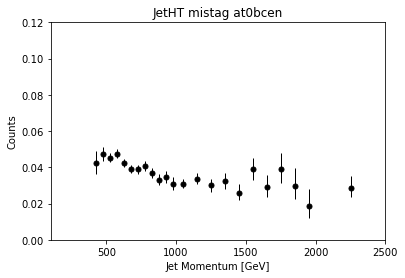

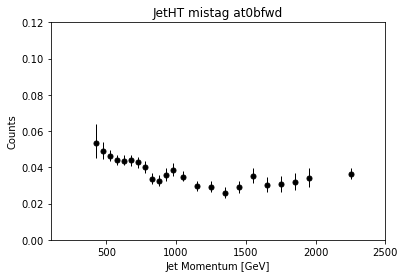

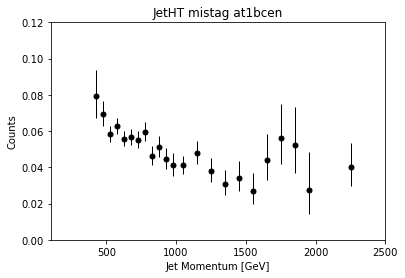

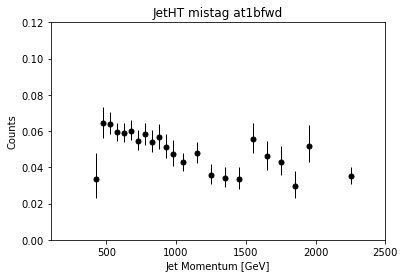

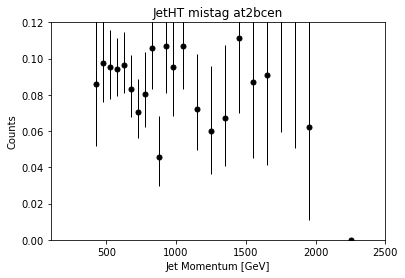

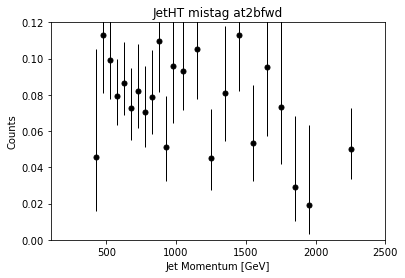

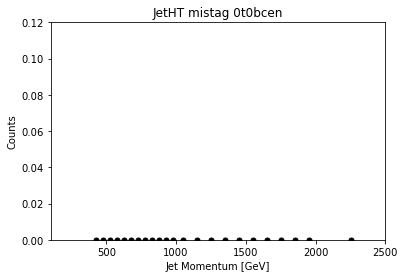

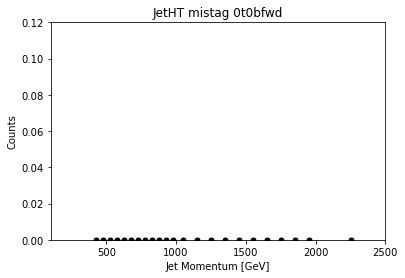

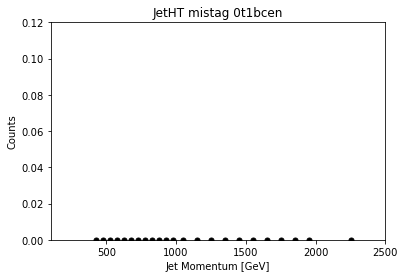

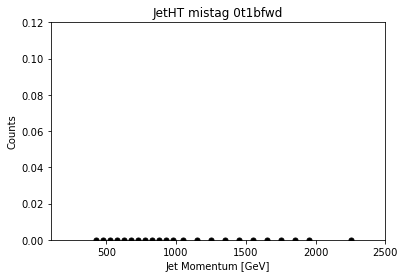

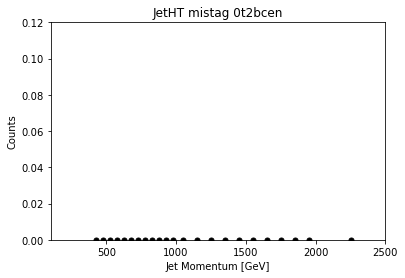

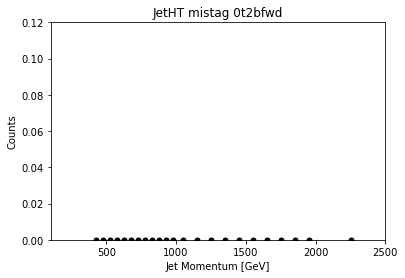

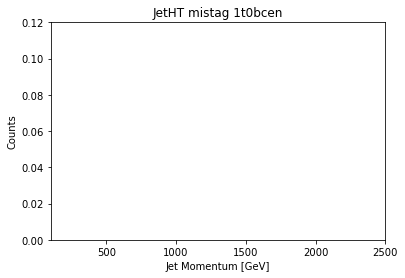

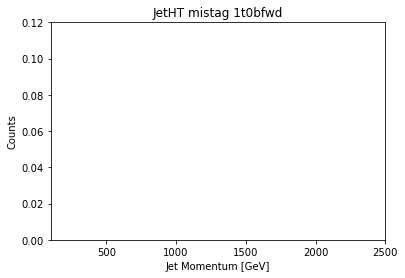

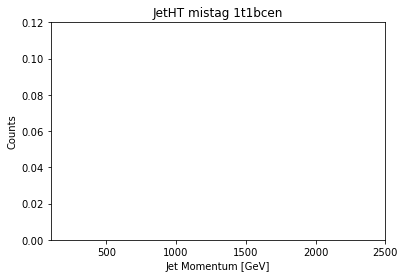

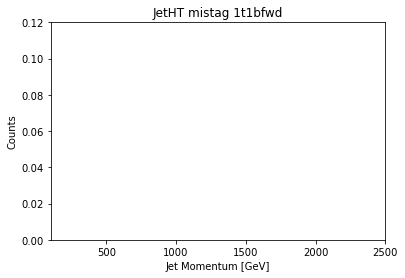

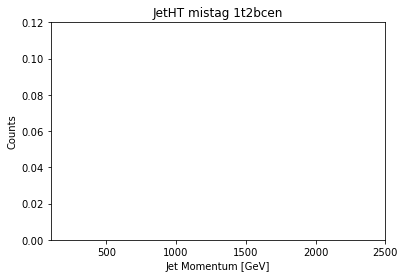

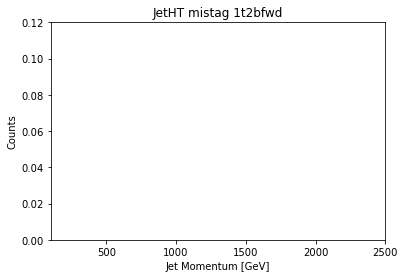

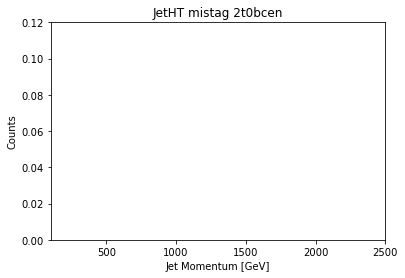

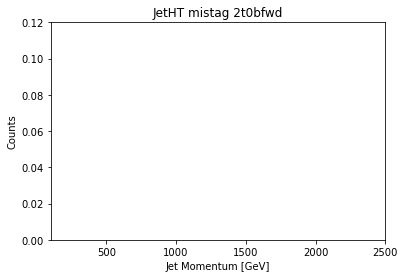

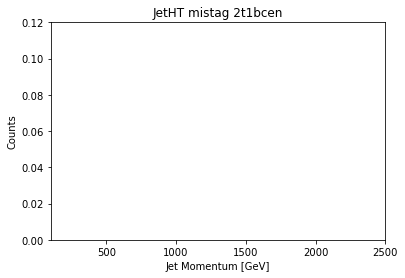

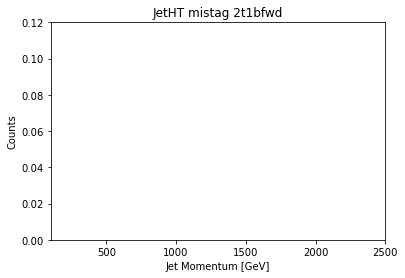

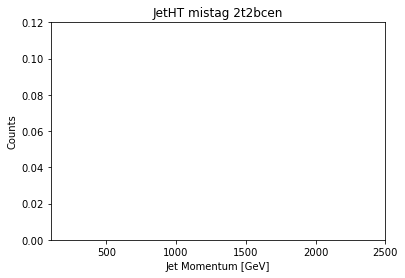

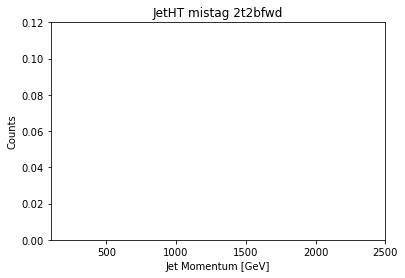

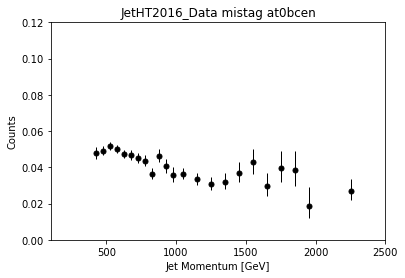

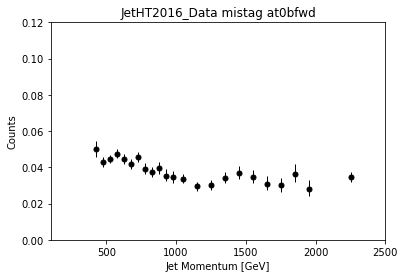

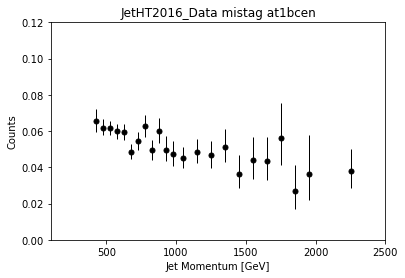

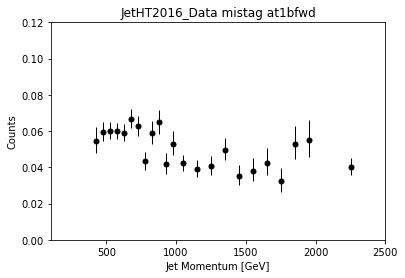

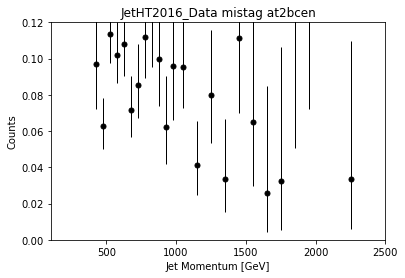

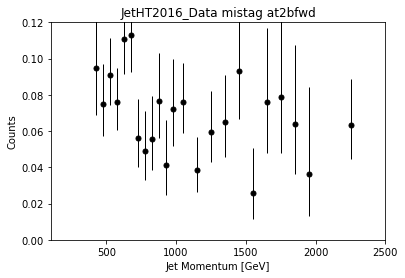

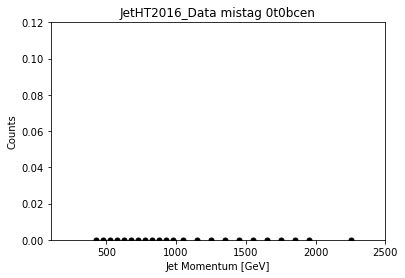

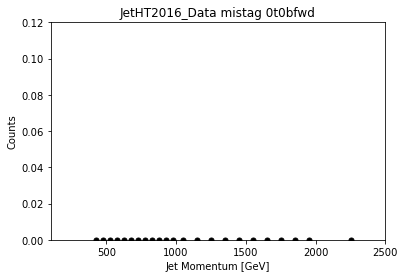

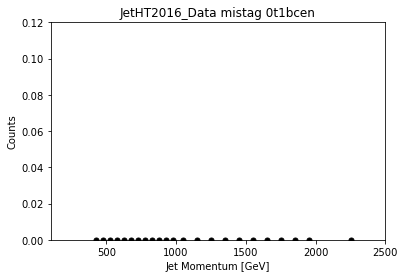

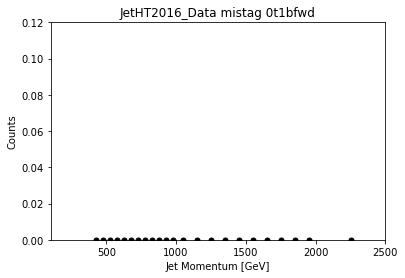

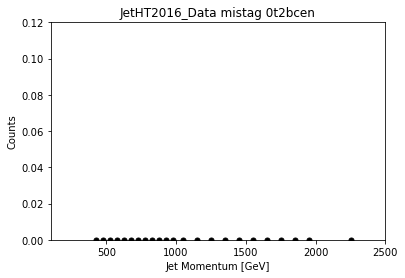

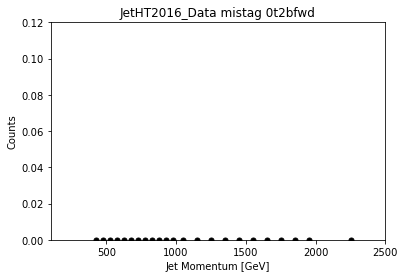

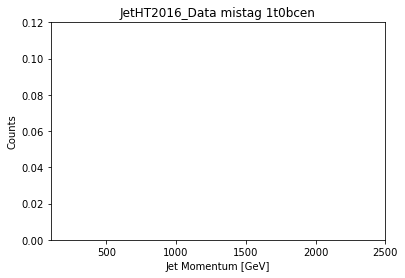

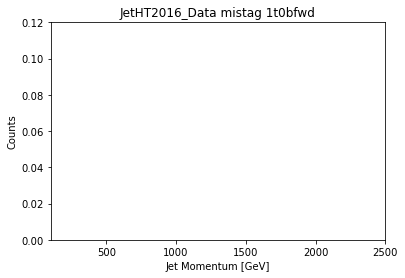

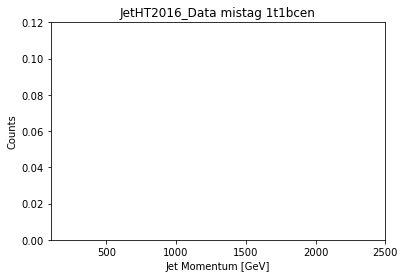

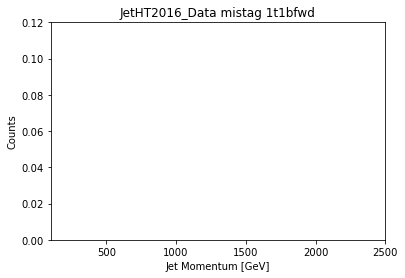

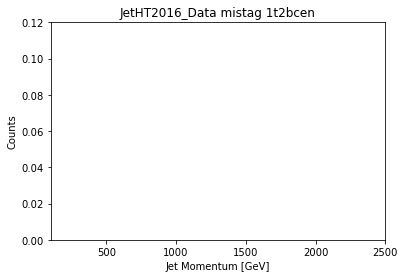

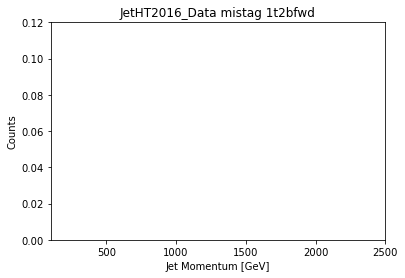

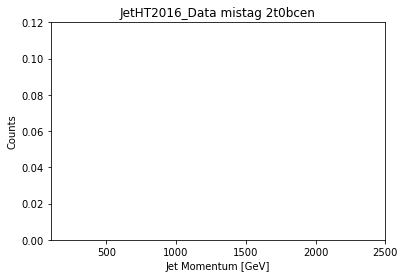

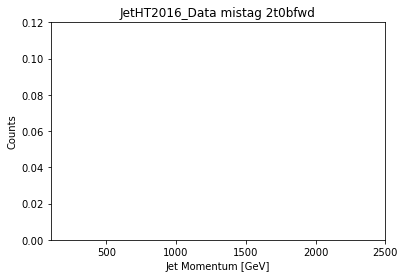

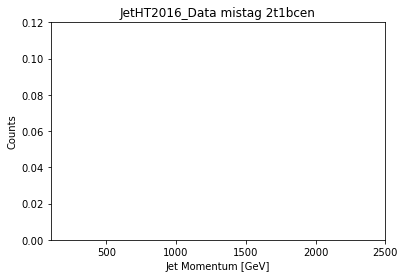

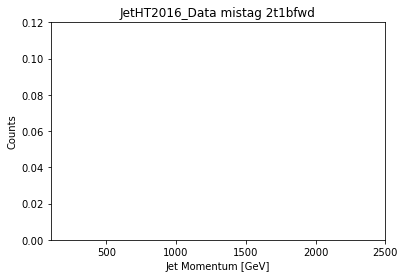

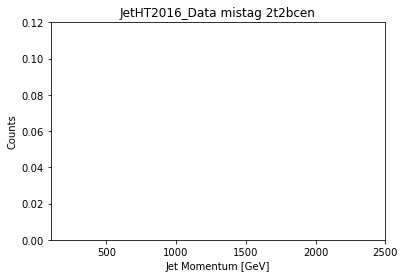

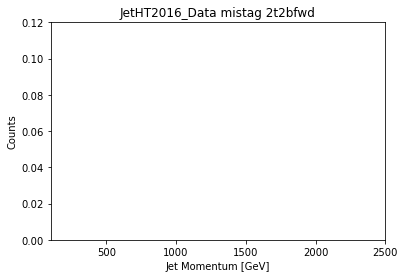

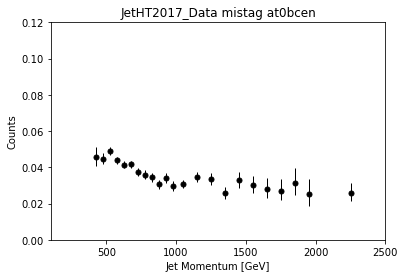

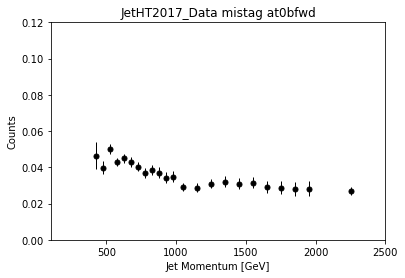

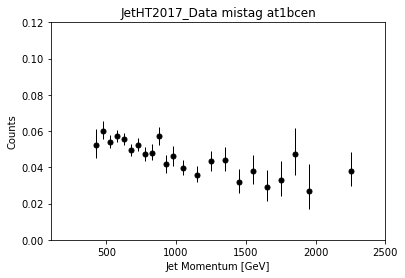

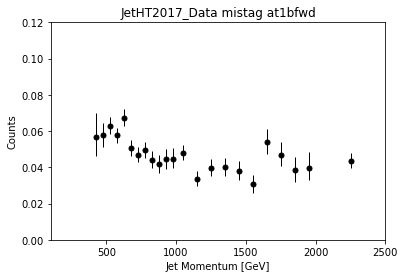

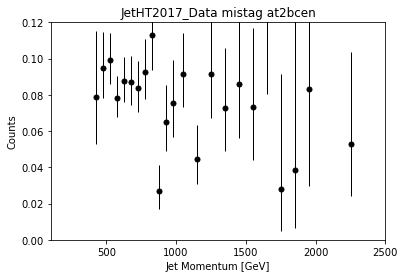

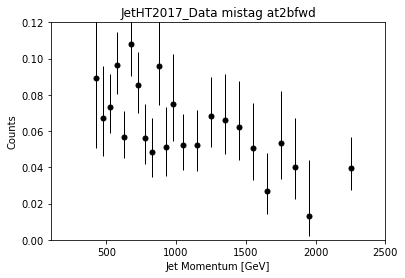

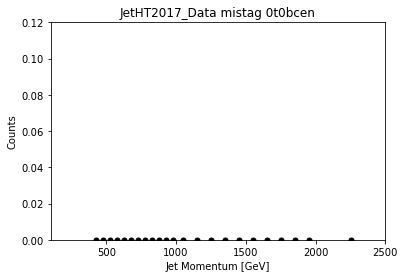

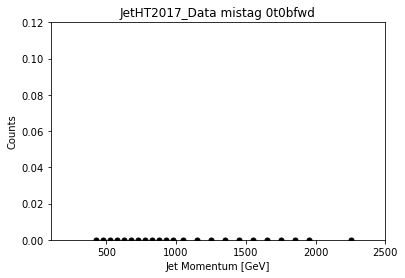

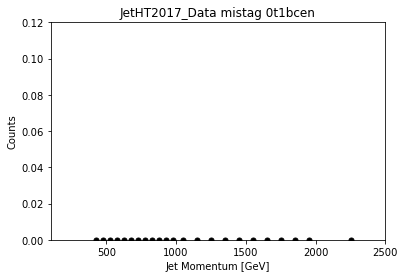

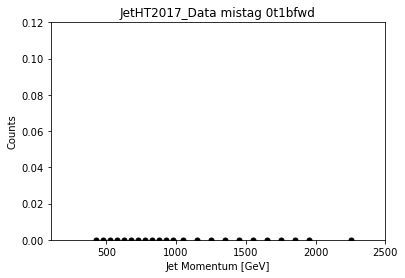

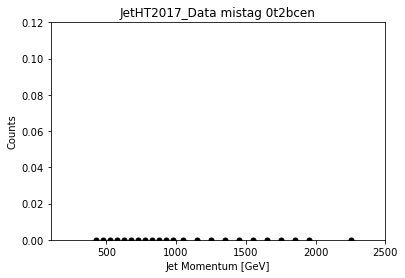

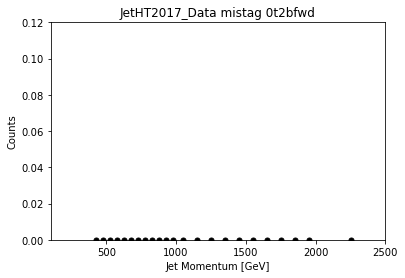

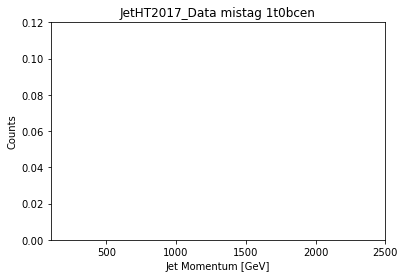

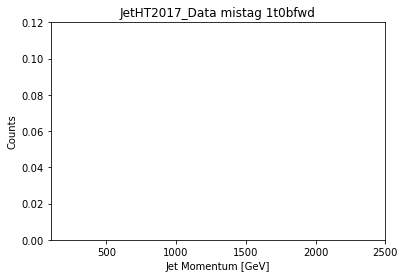

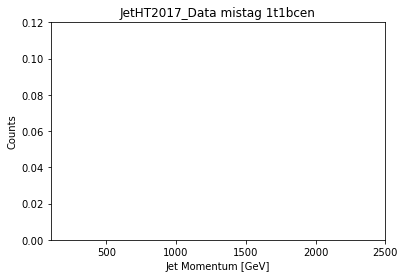

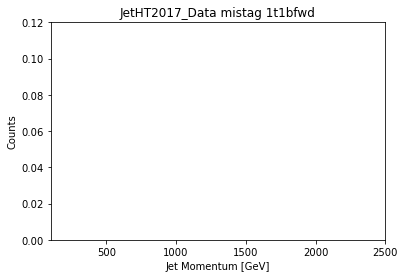

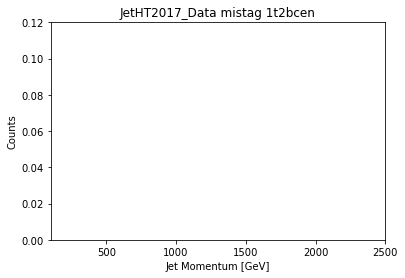

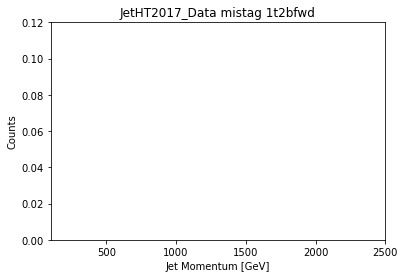

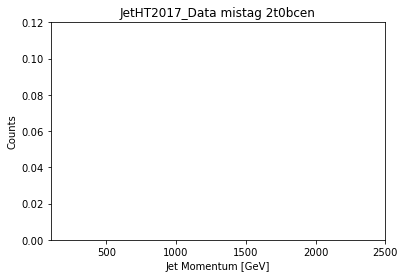

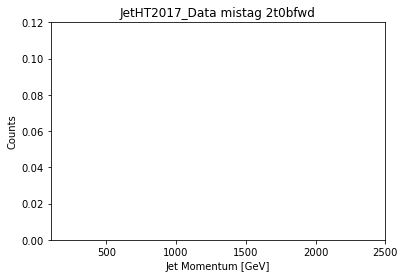

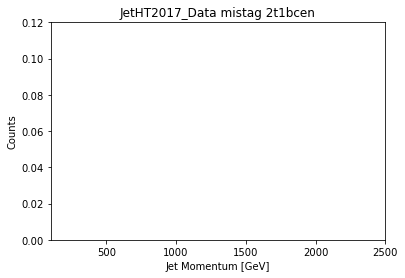

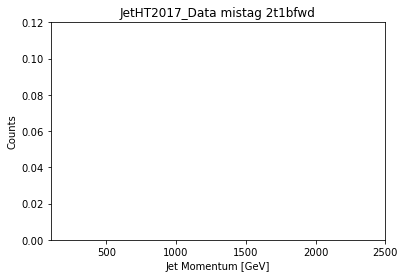

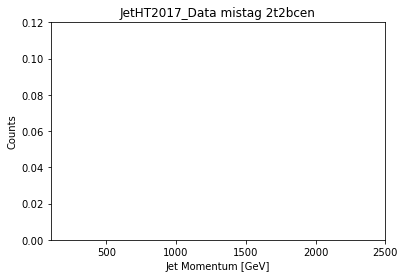

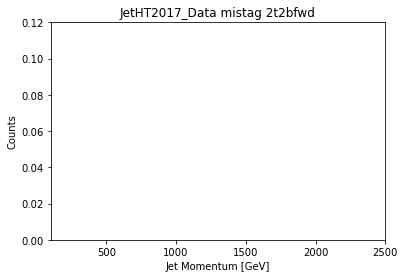

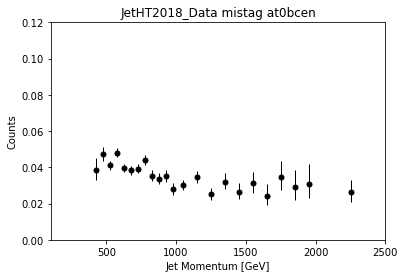

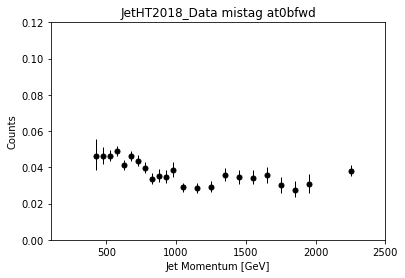

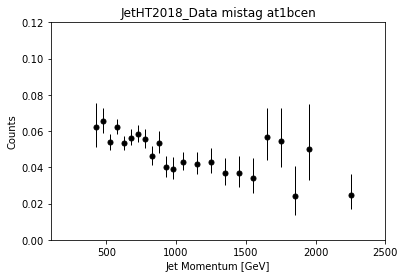

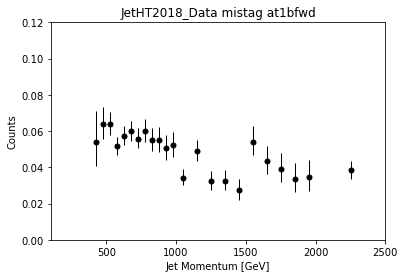

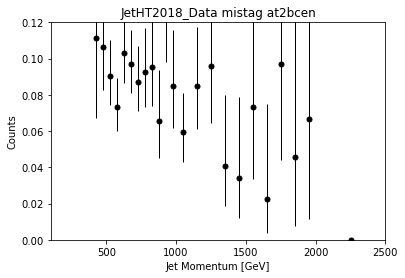

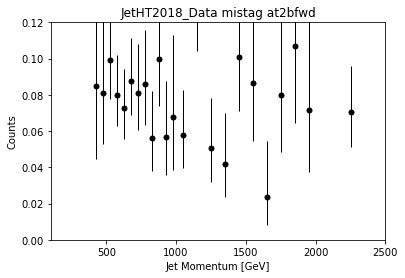

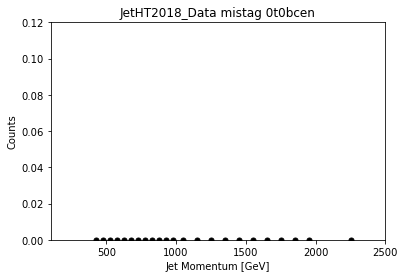

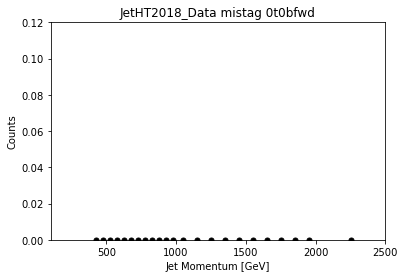

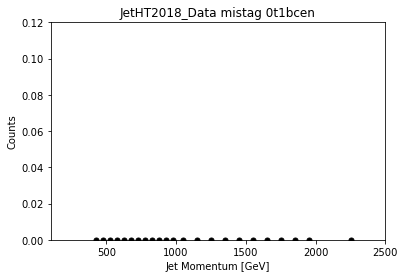

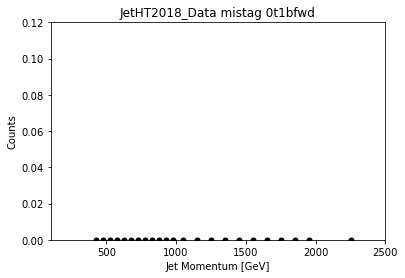

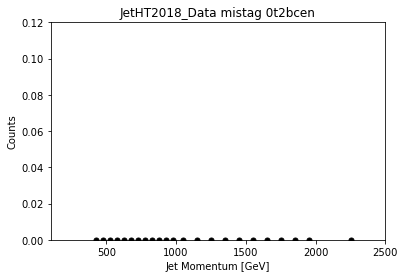

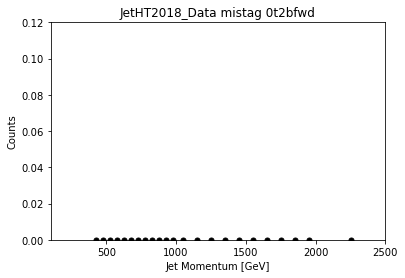

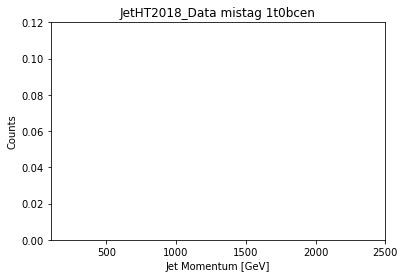

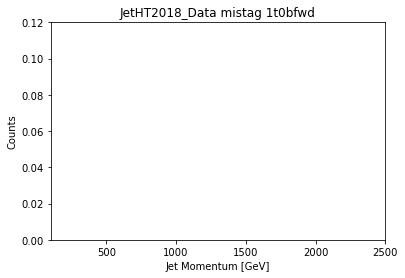

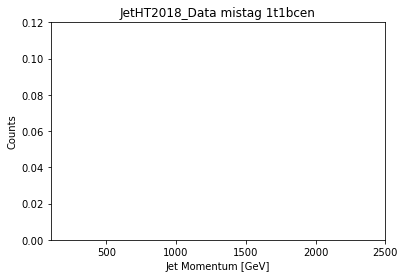

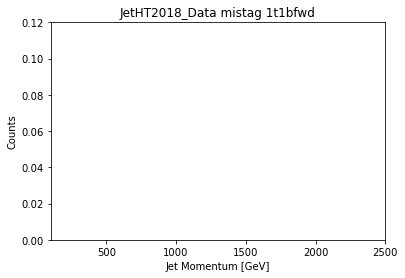

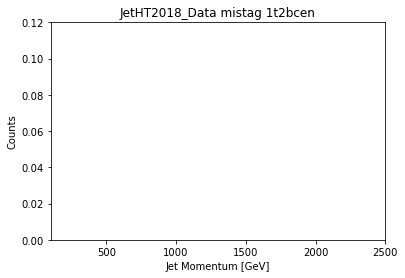

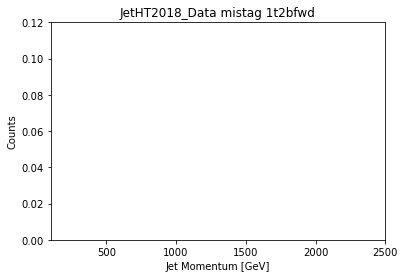

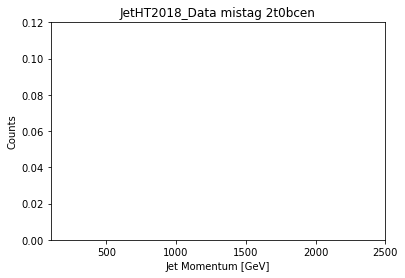

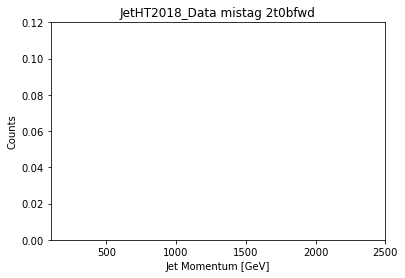

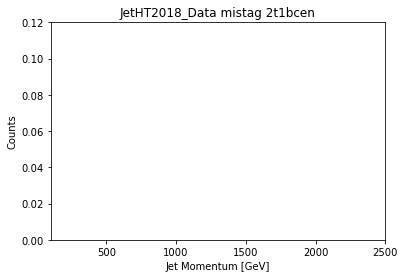

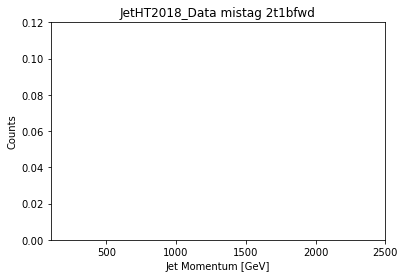

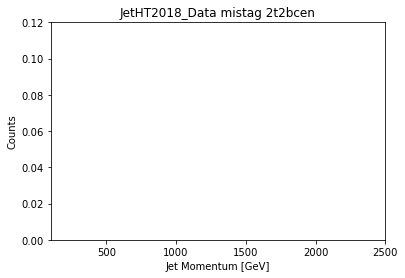

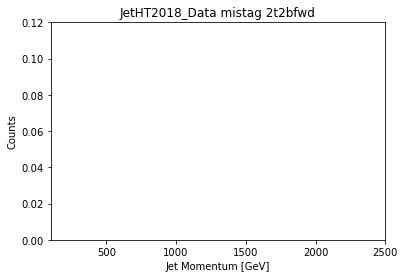

In [19]:
""" ---------------- CREATES MISTAG PLOTS ---------------- """
# ---- Only Use This Cell When LookUp Tables Are Not In Use (i.e. UseLookUpTables = False) ---- #

SaveDirectory = maindirectory + '/MistagPlots/'
DoesDirectoryExist(SaveDirectory) # no need to create the directory several times

# Function sqrt(x)
def forward(x):
    return x**(1/2)


def inverse(x):
    return x**2

print(SaveDirectory)
for iset in filesets:
    for icat in list_of_cats:
        print(iset)
        print(icat)
        title = iset + ' mistag ' + icat
        filename = 'mistag_' + iset + '_' + icat + '.' + 'png'
        print(outputs_unweighted[iset]['numerator'])
        Numerator = outputs_unweighted[iset]['numerator'].integrate('anacat', icat).integrate('dataset', iset)
        Denominator = outputs_unweighted[iset]['denominator'].integrate('anacat', icat).integrate('dataset', iset)
        print(Numerator)
        print(Denominator)
        mistag = hist.plotratio(num = Numerator, denom = Denominator,
                                error_opts={'marker': '.', 'markersize': 10., 'color': 'k', 'elinewidth': 1},
                                unc = 'num')
        plt.title(title)
        plt.ylim(bottom = 0, top = 0.12)
        plt.xlim(left = 100, right = 2500)
        #plt.xticks(np.array([0, 500, 600, 700]))
        #mistag.set_xscale('function', functions=(forward, inverse))
        #mistag.set_xscale('log')
        
        #plt.savefig(SaveDirectory+filename, bbox_inches="tight")
        #print(filename + ' saved')


In [20]:
""" ---------------- LOOK UP TABLE ---------------- """
# ---- Only Use This Cell When LookUp Tables Are Not In Use (i.e. UseLookUpTables = False) ---- #
from collections import defaultdict

runLUTS = True 

def multi_dict(K, type): # definition from https://www.geeksforgeeks.org/python-creating-multidimensional-dictionary/
    if K == 1: 
        return defaultdict(type) 
    else: 
        return defaultdict(lambda: multi_dict(K-1, type))
    
luts = {}
luts = multi_dict(2, str)

if runLUTS : 

    SaveDirectory = maindirectory + '/LookupTables/'
    DoesDirectoryExist(SaveDirectory)



    for iset in filesets:
        print('\t\tfileset: ' + iset + '\n*****************************************************\n')
        for icat in list_of_cats:
            title = iset + ' mistag ' + icat
            filename = 'mistag_' + iset + '_' + icat + '.' + 'csv'

            Numerator = outputs_unweighted[iset]['numerator'].integrate('anacat',icat).integrate('dataset',iset)
            Denominator = outputs_unweighted[iset]['denominator'].integrate('anacat',icat).integrate('dataset',iset)
            
            
            
            N_vals = Numerator.values()[()]
            D_vals = Denominator.values()[()]
            print(N_vals)
            print(D_vals)
            print()
            mistag_vals = np.where(D_vals > 0, N_vals / D_vals, 0)


            p_vals = [] # Momentum values
            for iden in Numerator.identifiers('jetp'):
                p_vals.append(iden)
                
            
            print('fileset:  ' + iset)
            print('category: ' + icat)
            print('________________________________________________\n')

            d = {'p': p_vals, 'M(p)': mistag_vals}
            
            #print("p vals = ", p_vals)
            print("d vals = ", d)
            print()
            df = pd.DataFrame(data=d)
            luts[iset][icat] = df

            with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
                print(df)
            print('\n')

            df.to_csv(SaveDirectory+filename) # use later to collect bins and weights for re-scaling
else :
    for iset in filesets:
        print('\t\tfileset: ' + iset + '\n*****************************************************\n')
        for icat in list_of_cats:
            title = iset + ' mistag ' + icat
            filename = 'mistag_' + iset + '_' + icat + '.' + 'csv'
            luts[iset][icat] = pd.read_csv(filename)
print(luts)

		fileset: JetHT
*****************************************************

[ 51. 178. 346. 451. 382. 307. 268. 239. 184. 134. 123.  92. 146. 121.
  79.  64.  39.  47.  28.  28.  16.   8.  29.   7.   1.   0.   0.   0.]
[1.207e+03 3.766e+03 7.633e+03 9.487e+03 9.034e+03 7.881e+03 6.879e+03
 5.861e+03 5.028e+03 4.036e+03 3.561e+03 2.979e+03 4.729e+03 3.582e+03
 2.635e+03 1.989e+03 1.505e+03 1.211e+03 9.670e+02 7.210e+02 5.350e+02
 4.270e+02 1.009e+03 2.170e+02 3.900e+01 5.000e+00 0.000e+00 0.000e+00]

fileset:  JetHT
category: at0bcen
________________________________________________

d vals =  {'p': [<Interval ([400, 450)) instance at 0x7fd36058a0d0>, <Interval ([450, 500)) instance at 0x7fd36058a150>, <Interval ([500, 550)) instance at 0x7fd36058a1d0>, <Interval ([550, 600)) instance at 0x7fd36058a250>, <Interval ([600, 650)) instance at 0x7fd36058a3d0>, <Interval ([650, 700)) instance at 0x7fd36058a450>, <Interval ([700, 750)) instance at 0x7fd36058a4d0>, <Interval ([750, 800)) instance at

[ 38. 118. 231. 273. 270. 240. 212. 178. 132. 113. 114. 112. 174. 128.
 108.  80.  78.  86.  62.  56.  51.  48. 162.  56.  16.   2.   2.   0.]
[ 38. 118. 231. 273. 270. 240. 212. 178. 132. 113. 114. 112. 174. 128.
 108.  80.  78.  86.  62.  56.  51.  48. 162.  56.  16.   2.   2.   0.]

fileset:  JetHT
category: 1t0bfwd
________________________________________________

d vals =  {'p': [<Interval ([400, 450)) instance at 0x7fd36058a0d0>, <Interval ([450, 500)) instance at 0x7fd36058a150>, <Interval ([500, 550)) instance at 0x7fd36058a1d0>, <Interval ([550, 600)) instance at 0x7fd36058a250>, <Interval ([600, 650)) instance at 0x7fd36058a3d0>, <Interval ([650, 700)) instance at 0x7fd36058a450>, <Interval ([700, 750)) instance at 0x7fd36058a4d0>, <Interval ([750, 800)) instance at 0x7fd36058a550>, <Interval ([800, 850)) instance at 0x7fd36058a390>, <Interval ([850, 900)) instance at 0x7fd36058a5d0>, <Interval ([900, 950)) instance at 0x7fd36058a650>, <Interval ([950, 1000)) instance at 0x7f

[ 64. 147. 184. 183. 171. 165. 138.  88. 102. 102.  61.  73.  99.  79.
  68.  72.  47.  42.  40.  29.  40.  34.  77.  26.   6.   0.   1.   0.]
[1170. 2463. 3061. 3055. 2895. 2469. 2205. 2033. 1732. 1574. 1466. 1380.
 2350. 2017. 1678. 1445. 1326. 1101.  939.  899.  756.  620. 1919.  612.
  137.   31.    4.    0.]

fileset:  JetHT2016_Data
category: at1bfwd
________________________________________________

d vals =  {'p': [<Interval ([400, 450)) instance at 0x7fd360574250>, <Interval ([450, 500)) instance at 0x7fd360574c50>, <Interval ([500, 550)) instance at 0x7fd360574d50>, <Interval ([550, 600)) instance at 0x7fd360574e10>, <Interval ([600, 650)) instance at 0x7fd360574d10>, <Interval ([650, 700)) instance at 0x7fd360574350>, <Interval ([700, 750)) instance at 0x7fd360574850>, <Interval ([750, 800)) instance at 0x7fd360574710>, <Interval ([800, 850)) instance at 0x7fd360574990>, <Interval ([850, 900)) instance at 0x7fd3605748d0>, <Interval ([900, 950)) instance at 0x7fd360574510>, <I

[13. 18. 29. 24. 33. 30. 12.  9. 10. 14.  6. 12. 19.  9. 12. 11. 12.  3.
  7.  6.  5.  2. 11.  4.  1.  0.  0.  0.]
[13. 18. 29. 24. 33. 30. 12.  9. 10. 14.  6. 12. 19.  9. 12. 11. 12.  3.
  7.  6.  5.  2. 11.  4.  1.  0.  0.  0.]

fileset:  JetHT2016_Data
category: 1t2bfwd
________________________________________________

d vals =  {'p': [<Interval ([400, 450)) instance at 0x7fd360574250>, <Interval ([450, 500)) instance at 0x7fd360574c50>, <Interval ([500, 550)) instance at 0x7fd360574d50>, <Interval ([550, 600)) instance at 0x7fd360574e10>, <Interval ([600, 650)) instance at 0x7fd360574d10>, <Interval ([650, 700)) instance at 0x7fd360574350>, <Interval ([700, 750)) instance at 0x7fd360574850>, <Interval ([750, 800)) instance at 0x7fd360574710>, <Interval ([800, 850)) instance at 0x7fd360574990>, <Interval ([850, 900)) instance at 0x7fd3605748d0>, <Interval ([900, 950)) instance at 0x7fd360574510>, <Interval ([950, 1000)) instance at 0x7fd360574b90>, <Interval ([1000, 1100)) instance 

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
[1.8160e+03 5.5830e+03 1.0481e+04 1.2243e+04 1.1488e+04 9.8200e+03
 8.4040e+03 6.9940e+03 6.1460e+03 5.2800e+03 4.2820e+03 3.7220e+03
 5.8810e+03 4.3870e+03 3.4260e+03 2.5930e+03 1.9760e+03 1.5610e+03
 1.1740e+03 9.3400e+02 7.0700e+02 5.7700e+02 1.3150e+03 2.7200e+02
 4.2000e+01 3.0000e+00 0.0000e+00 0.0000e+00]

fileset:  JetHT2017_Data
category: 0t0bcen
________________________________________________

d vals =  {'p': [<Interval ([400, 450)) instance at 0x7fd3604bbf10>, <Interval ([450, 500)) instance at 0x7fd3604bb2d0>, <Interval ([500, 550)) instance at 0x7fd3604bbc50>, <Interval ([550, 600)) instance at 0x7fd3604c7090>, <Interval ([600, 650)) instance at 0x7fd3604c7190>, <Interval ([650, 700)) instance at 0x7fd3604c7890>, <Interval ([700, 750)) instance at 0x7fd3604c7b10>, <Interval ([750, 800)) instance at 0x7fd3604c7350>, <Interval ([800, 850)) instance at 0x7fd3604c7790>, <Interval ([850, 900

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]

fileset:  JetHT2017_Data
category: 2t1bfwd
________________________________________________

d vals =  {'p': [<Interval ([400, 450)) instance at 0x7fd3604bbf10>, <Interval ([450, 500)) instance at 0x7fd3604bb2d0>, <Interval ([500, 550)) instance at 0x7fd3604bbc50>, <Interval ([550, 600)) instance at 0x7fd3604c7090>, <Interval ([600, 650)) instance at 0x7fd3604c7190>, <Interval ([650, 700)) instance at 0x7fd3604c7890>, <Interval ([700, 750)) instance at 0x7fd3604c7b10>, <Interval ([750, 800)) instance at 0x7fd3604c7350>, <Interval ([800, 850)) instance at 0x7fd3604c7790>, <Interval ([850, 900)) instance at 0x7fd3604c7ed0>, <Interval ([900, 950)) instance at 0x7fd3604c7e10>, <Interval ([950, 1000)) instance at 0x7fd3604c72d0>, <Interval ([1000, 1100)) instance at 0x7fd3604c7c10>, <Interval ([1100, 1200)) instance at

[ 46. 176. 305. 439. 348. 292. 259. 247. 171. 136. 120.  82. 143. 118.
  67.  63.  40.  37.  22.  24.  16.  14.  24.   4.   2.   1.   0.   0.]
[ 46. 176. 305. 439. 348. 292. 259. 247. 171. 136. 120.  82. 143. 118.
  67.  63.  40.  37.  22.  24.  16.  14.  24.   4.   2.   1.   0.   0.]

fileset:  JetHT2018_Data
category: 1t0bcen
________________________________________________

d vals =  {'p': [<Interval ([400, 450)) instance at 0x7fd3604e8e50>, <Interval ([450, 500)) instance at 0x7fd3604e8ad0>, <Interval ([500, 550)) instance at 0x7fd3604e8b50>, <Interval ([550, 600)) instance at 0x7fd3604e8bd0>, <Interval ([600, 650)) instance at 0x7fd3604e80d0>, <Interval ([650, 700)) instance at 0x7fd3604e8c10>, <Interval ([700, 750)) instance at 0x7fd3604e88d0>, <Interval ([750, 800)) instance at 0x7fd3604e8990>, <Interval ([800, 850)) instance at 0x7fd3604e86d0>, <Interval ([850, 900)) instance at 0x7fd3604e8a10>, <Interval ([900, 950)) instance at 0x7fd3604e8950>, <Interval ([950, 1000)) instanc

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]

fileset:  JetHT2018_Data
category: 2t0bcen
________________________________________________

d vals =  {'p': [<Interval ([400, 450)) instance at 0x7fd3604e8e50>, <Interval ([450, 500)) instance at 0x7fd3604e8ad0>, <Interval ([500, 550)) instance at 0x7fd3604e8b50>, <Interval ([550, 600)) instance at 0x7fd3604e8bd0>, <Interval ([600, 650)) instance at 0x7fd3604e80d0>, <Interval ([650, 700)) instance at 0x7fd3604e8c10>, <Interval ([700, 750)) instance at 0x7fd3604e88d0>, <Interval ([750, 800)) instance at 0x7fd3604e8990>, <Interval ([800, 850)) instance at 0x7fd3604e86d0>, <Interval ([850, 900)) instance at 0x7fd3604e8a10>, <Interval ([900, 950)) instance at 0x7fd3604e8950>, <Interval ([950, 1000)) instance at 0x7fd3604e8fd0>, <Interval ([1000, 1100)) instance at 0x7fd3604e8250>, <Interval ([1100, 1200)) instance at

defaultdict(<function multi_dict.<locals>.<lambda> at 0x7fd3632467a0>, {'JetHT': defaultdict(<class 'str'>, {'at0bcen':                p      M(p)
0     [400, 450)  0.042254
1     [450, 500)  0.047265
2     [500, 550)  0.045329
3     [550, 600)  0.047539
4     [600, 650)  0.042285
5     [650, 700)  0.038954
6     [700, 750)  0.038959
7     [750, 800)  0.040778
8     [800, 850)  0.036595
9     [850, 900)  0.033201
10    [900, 950)  0.034541
11   [950, 1000)  0.030883
12  [1000, 1100)  0.030873
13  [1100, 1200)  0.033780
14  [1200, 1300)  0.029981
15  [1300, 1400)  0.032177
16  [1400, 1500)  0.025914
17  [1500, 1600)  0.038811
18  [1600, 1700)  0.028956
19  [1700, 1800)  0.038835
20  [1800, 1900)  0.029907
21  [1900, 2000)  0.018735
22  [2000, 2500)  0.028741
23  [2500, 3000)  0.032258
24  [3000, 3500)  0.025641
25  [3500, 4000)  0.000000
26  [4000, 5000)  0.000000
27  [5000, 7000)  0.000000, 'at0bfwd':                p      M(p)
0     [400, 450)  0.053597
1     [450, 500)  0.048983
2   

In [21]:
print("Events/s:", output['cutflow']['all events']/elapsed)

In [22]:
filesets = {
    #'QCD':qcdfiles,
    #'TTbar':ttbarfiles
    'JetHT':jetdatafiles,
    'JetHT2016_Data':jetdatafiles2016,
    'JetHT2017_Data':jetdatafiles2017,
    'JetHT2018_Data':jetdatafiles2018
}

Events/s: 38589.80284295536


In [23]:
tstart = time.time()

outputs_weighted = {}

prng = RandomState(seed)

for name,files in filesets.items(): 
    

    print(name)
    output = processor.run_uproot_job({name:files},
                                      treename='Events',
                                      processor_instance=TTbarResProcessor(UseLookUpTables=True,
                                                                           lu=luts,
                                                                           prng=prng),
                                      executor=processor.dask_executor,
                                      #executor=processor.iterative_executor,
                                      #executor=processor.futures_executor,
                                      executor_args={
                                          'client': client, 
                                          'nano':False, 
                                          'flatten':True, 
                                          'skipbadfiles':False,
                                          'workers': 2},
                                      chunksize=100000, maxchunks=600
                                     )

    elapsed = time.time() - tstart
    outputs_weighted[name] = output
    print(output)
    util.save(output, 'TTbarResCoffea_' + name + '_weighted_output.coffea')

JetHT
['At0bcen', 'At0bfwd', 'At1bcen', 'At1bfwd', 'At2bcen', 'At2bfwd', 'at0bcen', 'at0bfwd', 'at1bcen', 'at1bfwd', 'at2bcen', 'at2bfwd', '0t0bcen', '0t0bfwd', '0t1bcen', '0t1bfwd', '0t2bcen', '0t2bfwd', '1t0bcen', '1t0bfwd', '1t1bcen', '1t1bfwd', '1t2bcen', '1t2bfwd', '2t0bcen', '2t0bfwd', '2t1bcen', '2t1bfwd', '2t2bcen', '2t2bfwd']
{'ttbarmass': <Hist (dataset,anacat,ttbarmass) instance at 0x7fd34b9db750>, 'jetmass': <Hist (dataset,anacat,jetmass) instance at 0x7fd361211a10>, 'jetpt': <Hist (dataset,anacat,jetpt) instance at 0x7fd34bd6d110>, 'jeteta': <Hist (dataset,anacat,jeteta) instance at 0x7fd34b9db850>, 'probept': <Hist (dataset,anacat,jetpt) instance at 0x7fd3630eaed0>, 'probep': <Hist (dataset,anacat,jetp) instance at 0x7fd3630ea810>, 'jetphi': <Hist (dataset,anacat,jetphi) instance at 0x7fd3630eafd0>, 'jety': <Hist (dataset,anacat,jety) instance at 0x7fd3630eae90>, 'jetdy': <Hist (dataset,anacat,jetdy) instance at 0x7fd349fddb90>, 'subjetmass': <Hist (dataset,anacat,subjetm

In [24]:
for name,output in outputs_weighted.items(): 
    print("-------weighted " + name + "--------")
    for i,j in output['cutflow'].items():        
        print( '%20s : %12d' % (i,j) )

-------weighted JetHT--------
          all events :     60068644
              jet id :      2679073
             jet kin :      2627503
two FatJets and jet kin :      2221065
     >= one oneTTbar :      2217107
          dPhi > 2.1 :      1151734
                sumw :      1125607
               sumw2 :      1125607
             At0bcen :         3368
             At0bfwd :         3140
             At1bcen :         1868
             At1bfwd :         1699
             At2bcen :          325
             At2bfwd :          268
             at0bcen :        86923
             at0bfwd :        83930
             at1bcen :        35384
             at1bfwd :        33429
             at2bcen :         3723
             at2bfwd :         3406
             0t0bcen :       350292
             0t0bfwd :       340549
             0t1bcen :       130040
             0t1bfwd :       125151
             0t2bcen :        12153
             0t2bfwd :        11323
             1t0bcen :        5